In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw, dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import get_time_series2 as get_time_series 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, Activation, LSTM, Conv1D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.metrics import BinaryAccuracy, CosineSimilarity, Accuracy, categorical_accuracy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model, to_categorical 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tensorflow_addons.losses import contrastive_loss
from tensorflow_addons.metrics import F1Score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
year_data = 'Twitter16'
dest = 'tw16'

t = os.path.join('gdrive/My Drive/Master/Data', year_data, 'tree.tar.gz')
p = os.path.join('gdrive/My Drive/Master/Data', year_data, 'post.tar.gz')
u = os.path.join('gdrive/My Drive/Master/Data', year_data, 'users.tar.gz')
l = os.path.join('gdrive/My Drive/Master/Data', year_data, 'label.txt')

!mkdir "$dest"
!tar -xzvf "$t" -C "$dest"
!tar -xzvf "$p" -C "$dest"
!tar -xzvf "$u" -C "$dest"
!cp "$l" "$dest"

In [ ]:
%%time
dest = 'tw16'
data = get_time_series.data_process(dest, label_path='/label2_train.txt')

CPU times: user 42.2 s, sys: 7.06 s, total: 49.2 s
Wall time: 49.8 s


In [ ]:
%%time
window = 10
slide_window = True
time = 720
print('retweets, post, interactions')
labels, retweets, posts, tree_ids1 = get_time_series.get_interactions(data.news, window, slide_window, time)
interactions = retweets + posts
print('new users')
labels, new_users, tree_ids2 = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'new_users', window, slide_window, time)
print('followers')
labels, followers, tree_ids3 = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followers', window, slide_window, time)
print('followings')
labels, followings, tree_ids4 = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followings', window, slide_window, time)

retweets, post, interactions
new users
followers
followings
CPU times: user 1h 8min 14s, sys: 556 ms, total: 1h 8min 15s
Wall time: 1h 8min 19s


In [ ]:
tree_ids1 == tree_ids4

True

In [ ]:
print(labels.shape)
print(retweets.shape)
print(posts.shape)
print(interactions.shape)
print(new_users.shape)
print(followers.shape)
print(followings.shape)

(490,)
(490, 720)
(490, 720)
(490, 720)
(490, 720)
(490, 720)
(490, 720)


In [ ]:
%%time
dest = 'tw16'
data_test = get_time_series.data_process(dest, label_path='/label2_test.txt')

window = 10
slide_window = True
time = 720
print('retweets, post, interactions')
labels_test, retweets_test, posts_test, tree_ids_test = get_time_series.get_interactions(data_test.news, window, slide_window, time)
interactions_test = retweets_test + posts_test
print('new users')
labels_test, new_users_test, tree_ids_test = get_time_series.get_fingerprints(data_test.news, data_test.users, data_test.posts, 'new_users', window, slide_window, time)
print('followers')
labels_test, followers_test, tree_ids_test = get_time_series.get_fingerprints(data_test.news, data_test.users, data_test.posts, 'followers', window, slide_window, time)
print('followings')
labels_test, followings_test, tree_ids_test = get_time_series.get_fingerprints(data_test.news, data_test.users, data_test.posts, 'followings', window, slide_window, time)

retweets, post, interactions
new users
followers
followings
CPU times: user 19min 28s, sys: 6.7 s, total: 19min 35s
Wall time: 19min 36s


In [ ]:
def get_multivariate_series(time_series, labels, scale = 1): 
    paa = PiecewiseAggregateApproximation(n_segments=140) # equals the number of segments and samples!!!
    digits = []
    for i in range(72):
        digits.append(i*10)
    digits = np.array(digits)
    
    if scale == 0:
        time_series_scaled = []
        for ts in time_series:
            scaler = MinMaxScaler()
            # scaler = StandardScaler()
            scaler.fit(ts)
            ts = scaler.transform(ts)
            ts = ts.reshape(ts.shape[0],ts.shape[1])
            time_series_scaled.append(ts)
    elif scale == 1:
        time_series_scaled = []
        for ts in time_series:
            scaler = MinMaxScaler()
            scaler.fit(ts)
            ts = scaler.transform(ts)
            # print('1 ', ts.shape)
            ts = ts.reshape(ts.shape[0], ts.shape[1], 1)
            ts = paa.inverse_transform(paa.fit_transform(ts))
            # print(ts.shape)
            ts = ts[:,digits,:]
            # print(ts.shape)
            ts = ts.reshape(ts.shape[0],ts.shape[1])
            # print(ts.shape)
            time_series_scaled.append(ts)                
    time_series_multi = np.stack(time_series_scaled, axis=-1)
    return time_series_multi

In [ ]:
time_series = get_multivariate_series(time_series=[interactions, new_users, followers, followings], labels=labels, scale=1)

In [ ]:
time_series_test = get_multivariate_series(time_series=[interactions_test, new_users_test, followers_test, followings_test], labels=labels_test, scale=1)

In [ ]:
from collections import OrderedDict

news_labels_train = OrderedDict( [(tree_ids1[i],labels[i]) for i in range(len(tree_ids1))])
news_labels_test = OrderedDict([(tree_ids_test[i],labels_test[i]) for i in range(len(tree_ids_test))])

In [ ]:
print(len(news_labels_train))
print(len(news_labels_test))

490
164


In [ ]:
x_train = time_series
y_train = labels
x_test = time_series_test 
y_test = labels_test 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(490, 72, 4)
(490,)
(164, 72, 4)
(164,)


In [ ]:
def confusion_matrix(y_train, y_clus, n_prototypes):
    n_classes = np.unique(y_train).shape[0]
    conf = np.zeros((n_classes,n_prototypes), dtype=int)
    n_instances = y_clus.shape[0]
    for k in range(n_instances):
        i = y_train[k]
        j = y_clus[k]
        conf[i][j] += 1 
    return conf

def gini_coefficient(conf):
    n_classes = conf.shape[0]
    n_prototypes = conf.shape[1]
    gini = np.zeros(n_prototypes, dtype=float)
    for j in range(n_prototypes):
        acc = float(conf[:,j].sum())
        if acc > 0:
            for i in range(n_classes):
                ratio = float(conf[i,j])/acc #la proporción del cluster que fue asignado a esa clase
                gini[j] += pow(ratio, 2)
            gini[j] = round(1 - gini[j], 3)
        else:
            gini[j] = np.nan
    return gini

def matprint(mat, fmt="g"): #print confusion matrix
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T] 
    # print(col_maxes)
    for x in mat:
        # print(x)
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
    
def get_h_clus_(filepath):
    h_clus_ = []
    # filepath = 'tw16.hgr.part.40' #archivo del profe
    with open(filepath) as fp: 
        cix = fp.readline().rstrip('\n')
        h_clus_.append(int(cix))
        while cix:
            cix = fp.readline().rstrip('\n')
            if len(cix) > 0:
                h_clus_.append(int(cix))
    return np.array(h_clus_)

def get_cidx_(conf_):
    cidx_ = dict()
    for j in range(conf_.shape[1]):
        cl = np.argmax(conf_[:,j])
        cidx_[j] = cl  #Clase (0,1,2,3) a la que pertece cada cluster
    return cidx_

## CLustering

In [ ]:
def k_clustering(x_train, fe):
    print('start')
    n_prototypes = 20
    n_instances = x_train.shape[0]
    km_dba = TimeSeriesKMeans(n_clusters=n_prototypes, metric="dtw", init="k-means++")
    y_clus = km_dba.fit_predict(x_train[:,:,fe]) #serie de tiempo univariada, la fe-esima
    return km_dba, y_clus

In [ ]:
%%time 
#Obtener clustering para cada huella temporal con k=20
km_dba_0, y_clus_0 = k_clustering(x_train,0)
km_dba_1, y_clus_1 = k_clustering(x_train,1) 
km_dba_2, y_clus_2 = k_clustering(x_train,2) 
km_dba_3, y_clus_3 = k_clustering(x_train,3) 
# km_dba_4, y_clus_4 = k_clustering(x_train,4) 

start
start
start
start
CPU times: user 3min 17s, sys: 199 ms, total: 3min 18s
Wall time: 3min 18s


In [ ]:
#Obtener matriz de confusión por cada clustering de cada huella temporal
conf_0 = confusion_matrix(y_train,y_clus_0,20)
conf_1 = confusion_matrix(y_train,y_clus_1,20)
conf_2 = confusion_matrix(y_train,y_clus_2,20)
conf_3 = confusion_matrix(y_train,y_clus_3,20)

In [ ]:
#Obtener índice de gini por cada clustering de cada huella temporal
gini_0 = gini_coefficient(conf_0)
gini_1 = gini_coefficient(conf_1)
gini_2 = gini_coefficient(conf_2)
gini_3 = gini_coefficient(conf_3)
print(sum(gini_0)/20)
print(sum(gini_1)/20)
print(sum(gini_2)/20)
print(sum(gini_3)/20)
# print(sum(gini_4)/20)

0.41935
0.37614999999999993
0.23020000000000002
0.2338


In [ ]:
def to_hmetis(partitions,ginis):
    n_hyperedges = 0
    n_instances = partitions[0].shape[0]
    fh = open("tw16_12h_4st.hgr",'w')
    k = 0
    for partition in partitions:
        n_prototypes = np.unique(partition).shape[0]
        gini = ginis[k]    
        for i in range(n_prototypes): 
            gin = gini[i]   #inidice de gini del cluster actual
            if not np.isnan(gin):
                w = int(100*(1 - gin)) # check if an int is needed
                digits = np.where(partition == i)[0] #ids de las series del cluster actual
                csize = len(digits)
                if csize > 2:
                    line = str(w) + ' ' #peso
                    for j in range(csize):
                        line += str(digits[j]+1) + ' '  #vertices/series involucrados
                    line = line + '\n'
                    fh.write(line)
                    n_hyperedges += 1
                    # print(i, ' ', line)
        k += 1
    fh.close()
    with open("tw16_12h_4st.hgr", 'r+') as fp:
        lines = fp.readlines()     # lines is list of line, each element '...\n'
        one_line = str(n_hyperedges) + ' ' + str(n_instances) + ' 1\n'
        lines.insert(0, one_line)  # you can use any index if you know the line index
        fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
        fp.writelines(lines)
    # fh.write(str(n_hyperedges) + ' ' + str(n_instances) + ' 1\n')
    return n_hyperedges, n_instances

In [ ]:
gini_4 = np.zeros(4, dtype=float)
to_hmetis([y_clus_0,y_clus_1,y_clus_2,y_clus_3,y_train], [gini_0,gini_1,gini_2,gini_3,gini_4])

(50, 490)

In [ ]:
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/hmetis/hmetis-1.5-linux.tar.gz  
!gunzip hmetis-1.5-linux.tar.gz
!tar -xvf hmetis-1.5-linux.tar

In [ ]:
!./hmetis-1.5-linux/khmetis ./tw16_12h_4st.hgr 40 5 1000 3 1 3 0

## Prototipos

In [ ]:
h_clus_40 = get_h_clus_('tw16_12h_4st.hgr.part.40')
print(h_clus_40.shape)
conf_40 = confusion_matrix(y_train,h_clus_40,40)
matprint(conf_40)
gini_40 = gini_coefficient(conf_40)
print(sum(gini_40)/40)
cidx_40 = get_cidx_(conf_40)

(490,)
4  2  5  3  5  4  2  4  2  2  3  1  1  3  5  5  2  3  2  2  2  3  2  6  4  4  0  6   1  5  4  5  2  5  6  1  0  4  3  5  
2  4  2  0  0  4  1  6  2  2  4  2  3  4  1  4  2  6  1  3  5  5  4  3  3  2  6  4   0  2  3  5  4  4  3  6  6  4  5  4  
5  2  2  6  1  4  7  1  5  3  2  4  3  2  3  2  5  1  2  4  3  3  1  0  3  4  2  1  10  3  1  2  2  1  2  2  5  3  1  2  
2  5  4  4  7  1  3  2  4  6  3  5  5  3  3  1  3  2  7  3  2  1  5  3  2  2  4  1   1  2  4  0  4  2  1  3  1  1  3  1  
0.6683250000000001


In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw

def ba_computing(h_clus_,x_train,cidx_): #h_clus_: Cluster al que pertece cada noticia, cidx_: Clase (0,1,2,3) a la que pertece cada cluster
    n_instances = h_clus_.shape[0]
    n_prototypes = len(np.unique(h_clus_)) #40 por ejemplo
    prototypes = []
    for i in range(n_prototypes):
        digits = np.where(h_clus_ == i)[0] #ids de noticias de ese cluster
        cls = cidx_[i] # clase del cluster
        x_ = x_train[digits,:,:] #datos agrupados en el i-ésimo cluster 
        y_ = y_train[digits]
        digits_ = np.where(y_ == cls)[0] #ids de datos en que coincide la clase real y la del cluster
        ba = dtw_barycenter_averaging(x_[digits_,:,:]) #obtener el prototipo
        prototypes.append(ba) 
    return np.array(prototypes)

In [ ]:
prototypes_40 = ba_computing(h_clus_40,x_train,cidx_40)
print(prototypes_40.shape)

(40, 72, 4)


## P-SN

In [ ]:
from random import randint

def unassigned(x,y,prototypes,cidx):
    max_dis = np.inf
    arg_min = 0
    for pid in cidx.keys():  #revisar cada cluster
        cl = cidx[pid]      #clase del cluster
        if cl == y:         #encontrar coincidencia de la clase del cluster con la clase real
            p = prototypes[pid]     #prototipo del cluster
            dis = dtw(x,p) 
            if dis < max_dis:
                arg_min = pid
                max_dis = dis
    return arg_min  #id del prototipo con distancia minima a la instancia x

def create_pairs(x, y, prototypes, h_clus, cidx):
        pairs = [] 
        labels = []
        n_classes = np.unique(y).shape[0]
        n_prototypes = prototypes.shape[0] 
        n_instances = x.shape[0]
        for i in range(n_instances):
            pid = h_clus[i]   #cluster al que pertenece la instancia
            cl_pr = cidx[pid]  #clase a la que pertenece el cluster de la instancia  --> clase prototipo
            cl_gr = y[i]        #ground truth
            if cl_pr != cl_gr:
                pid = unassigned(x[i], cl_gr, prototypes, cidx)
            p = prototypes[pid]
            for pix in np.delete(np.arange(n_prototypes), pid):
                if cidx[pix] != cl_gr:
                    _p = prototypes[pix]
                    pairs += [[x[i], p]]
                    labels += [0]
                    pairs += [[x[i], _p]]
                    labels += [1]         
        pairs, labels = shuffle(np.array(pairs), np.array(labels), random_state=0)
        return pairs, labels 

In [ ]:
tr_pairs_50, tr_y_50 =  create_pairs(x_train, y_train, prototypes_40, h_clus_40, cidx_40)
print(tr_pairs_50.shape, tr_y_50.shape)

(53636, 2, 18, 4) (53636,)


In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.1)(x)
    return Model(input, x)
    
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred != y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
tr_y_50 = tf.cast(tr_y_50, dtype='float32')
input_shape = tr_pairs_50.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_50 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_50.compile(loss=contrastive_loss, optimizer=rms)
history_50 = model_50.fit([tr_pairs_50[:, 0], tr_pairs_50[:, 1]], tr_y_50, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

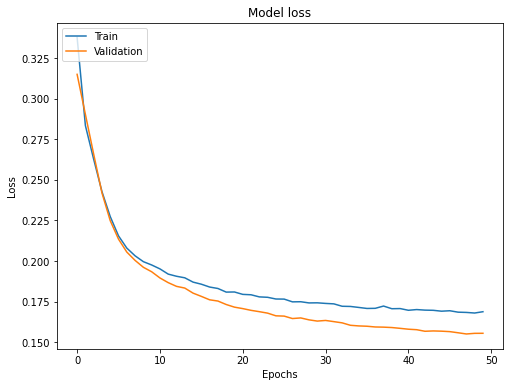

0.7864680438511448


In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(history_50.history['loss'])
plt.plot(history_50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim(0,1.0)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

y_pred = model_50.predict([tr_pairs_50[:,0],tr_pairs_50[:,1]])
print(compute_accuracy(tr_y_50, y_pred))

In [ ]:
def get_instance(x_ins, prototypes, model_):
    n_prototypes = prototypes.shape[0]
    outcomes = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        x_test_pair = np.empty([0, 2, x_ins.shape[0], x_ins.shape[1]])
        pair = np.array([[x_ins, prototypes[i]]])
        x_test_pair = np.append(x_test_pair, pair, axis=0)
        outcomes[i] = model_.predict([x_test_pair[:, 0], x_test_pair[:, 1]])
    return outcomes

def get_bias(x_train,prototypes,model_):
    n_prototypes = prototypes.shape[0]
    n_instances = x_train.shape[0]
    outcomes = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes[i,:] = get_instance(x_train[i],prototypes,model_)
    
    means = np.arange(n_prototypes, dtype=float)
    desvs = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        means[i] = np.mean(outcomes[:,i])
        desvs[i] = np.std(outcomes[:,i])
    return means, desvs, outcomes

def get_unbias(outcomes, means):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes_[i,:] = outcomes[i,:] - means
    return outcomes_

In [ ]:
%%time
means_tr_50, desvs_tr_50, outcomes_tr_50 = get_bias(x_train,prototypes_40,model_50)
means_te_50, desvs_te_50, outcomes_te_50 = get_bias(x_test,prototypes_40,model_50)
outcomes_tr_un_50 = get_unbias(outcomes_tr_50,means_tr_50)
outcomes_te_un_50 = get_unbias(outcomes_te_50,means_tr_50)
print(means_tr_50.shape, desvs_tr_50.shape, outcomes_tr_50.shape)
print(means_te_50.shape, desvs_te_50.shape, outcomes_te_50.shape)
print(outcomes_tr_un_50.shape, outcomes_te_un_50.shape)

(40,) (40,) (894, 40)
(40,) (40,) (298, 40)
(894, 40) (298, 40)
CPU times: user 35min 27s, sys: 35.7 s, total: 36min 3s
Wall time: 35min 43s


In [ ]:
def eval_instance(i,outcomes,y,cidx_,verbose=False):
    if verbose: 
        print("GT:",y[i])
        print("PR:",cidx_[np.argmin(outcomes[i,:])], np.argmin(outcomes[i,:]))
        print(y[i] == cidx_[np.argmin(outcomes[i,:])])
        print(outcomes[i,])
    return y[i] == cidx_[np.argmin(outcomes[i,:])]

def get_accuracy(outcomes,y,cidx_):
    accum = 0
    n_instances = outcomes.shape[0]
    for i in range(n_instances):
        val = eval_instance(i,outcomes,y,cidx_)
        if (val == True): accum += 1
    return accum/n_instances

In [ ]:
print(get_accuracy(outcomes_tr_un_50,y_train,cidx_40))
print(get_accuracy(outcomes_te_un_50,y_test,cidx_40))

0.46868008948545864
0.4429530201342282


In [ ]:
def get_ml_set(outcomes):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        xls = outcomes[i,:]*-1   #Cambiar sentido de la distancia, mientras más cerca mejor
        xls = xls - np.min(xls)
        xls = xls/np.max(xls)
        outcomes_[i,:] = xls    # resultados normalizado
    return outcomes_

In [ ]:
outcomes_training_50 = get_ml_set(outcomes_tr_50)
outcomes_testing_50 = get_ml_set(outcomes_te_50)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_50 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=None, validation_fraction=0.25, verbose=False, max_iter=10000)
clf_50.fit(outcomes_training_50,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 4), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.25, verbose=False,
              warm_start=False)

In [ ]:
print(clf_50.score(outcomes_training_50,y_train))
print(clf_50.score(outcomes_testing_50,y_test))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average='macro'))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average='macro'))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average=None))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average=None))

0.5346938775510204
0.5365853658536586

0.5279946263069816
0.5303065994161771

[0.4940239  0.73846154 0.54320988 0.33628319]
[0.57731959 0.69444444 0.51612903 0.33333333]


In [ ]:
print(clf_50.score(outcomes_training_50,y_train))
print(clf_50.score(outcomes_testing_50,y_test))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average='macro'))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average='macro'))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average=None))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average=None))

0.5693877551020409
0.524390243902439

0.5472826094861347
0.5170529671200884

[0.56074766 0.74       0.55677656 0.33160622]
[0.56790123 0.65853659 0.53191489 0.30985915]


In [ ]:
print(clf_50.score(outcomes_training_50,y_train))
print(clf_50.score(outcomes_testing_50,y_test))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average='macro'))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average='macro'))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average=None))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average=None))

0.7224489795918367
0.49390243902439024

0.7098800041531829
0.4842978000537448

[0.74103586 0.86692015 0.70848708 0.52307692]
[0.6185567  0.55696203 0.3902439  0.37142857]


### Concatenar TD-RvNN y P-SN

In [ ]:
news_labels_train

In [ ]:
#Concatenar outputs P-SN y TD-RvNN
with open('tw15_3h_4_train.npy', 'rb') as f:
    torch_rvnn_train = np.load(f, allow_pickle=True).item()
with open('tw15_3h_4_test.npy', 'rb') as f:
    torch_rvnn_test = np.load(f, allow_pickle=True).item()

In [ ]:
print(len(torch_rvnn_train))
print(outcomes_training_50.shape)
print(len(torch_rvnn_test))
print(outcomes_testing_50.shape)

894
(894, 40)
298
(298, 40)


In [ ]:
#Parear historias
def get_concat_set(news_labels, outcomes, torch_rvnn):
    outcomes_pairs = []
    y_concat = []
    for i, (tree_id, label) in enumerate(news_labels.items()):
        # print(i, tree_id, label)
        # print(outcomes_training_50[i].shape)
        # print(torch_rvnn_train[str(tree_id)].shape)
        concat = np.concatenate((outcomes[i], torch_rvnn[str(tree_id)]), axis=None)
        outcomes_pairs.append(concat)
        y_concat.append(label)
    return np.array(outcomes_pairs), np.array(y_concat)

In [ ]:
outcomes_train_pairs, y_train_concat = get_concat_set(news_labels_train, outcomes_training_50, torch_rvnn_train)
print(outcomes_train_pairs.shape)
print(y_train_concat.shape)

(894, 140)
(894,)


In [ ]:
outcomes_test_pairs, y_test_concat = get_concat_set(news_labels_test, outcomes_testing_50, torch_rvnn_test)
print(outcomes_test_pairs.shape)
print(y_test_concat.shape)

(298, 140)
(298,)


In [ ]:
clf_50_concat = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=None, validation_fraction=0.25, verbose=False, max_iter=10000)
clf_50_concat.fit(outcomes_train_pairs,y_train_concat)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 4), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.25, verbose=False,
              warm_start=False)

In [ ]:
#12h
print(clf_50_concat.score(outcomes_train_pairs,y_train_concat))
print(clf_50_concat.score(outcomes_test_pairs,y_test_concat))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average='macro'))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average='macro'))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average=None))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average=None))

0.9836734693877551
0.7865853658536586

0.9828231606122073
0.7907759641670895

[0.99607843 1.         0.96969697 0.96551724]
[0.93333333 0.79518072 0.72727273 0.70731707]


In [ ]:
#24h
print(clf_50_concat.score(outcomes_train_pairs,y_train_concat))
print(clf_50_concat.score(outcomes_test_pairs,y_test_concat))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average='macro'))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average='macro'))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average=None))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average=None))

0.9938775510204082
0.7682926829268293

0.9935060067095227
0.7694364359911299

[1.         1.         0.98689956 0.98712446]
[0.86842105 0.80952381 0.74157303 0.65822785]


In [ ]:
#48h
print(clf_50_concat.score(outcomes_train_pairs,y_train_concat))
print(clf_50_concat.score(outcomes_test_pairs,y_test_concat))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average='macro'))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average='macro'))
print()
print(f1_score(clf_50_concat.predict(outcomes_train_pairs),y_train_concat, average=None))
print(f1_score(clf_50_concat.predict(outcomes_test_pairs),y_test_concat, average=None))

0.9959183673469387
0.7317073170731707

0.9958982320422473
0.7301068818464254

[0.99588477 1.         0.99570815 0.992     ]
[0.87058824 0.72727273 0.63291139 0.68965517]
